In [69]:
# %pip install --upgrade 'google-meridian[and-cuda]'

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from meridian.data import data_frame_input_data_builder as data_builder
import tensorflow_probability as tfp
from meridian import constants
from meridian.model import model, prior_distribution, spec
from meridian.analysis.review import reviewer
from meridian.analysis import visualizer
from meridian.analysis import analyzer as analyzer_lib
from meridian.analysis import optimizer

df = pd.read_csv("monthly_mocha.csv")

df.head()

,date,subscriptions,meta_spend,meta_impressions,google_spend,google_impressions,snapchat_spend,snapchat_impressions,tiktok_spend,tiktok_impressions,moloco_spend,moloco_impressions,liveintent_spend,liveintent_impressions,roku_spend,roku_impressions,beehiiv_spend,beehiiv_impressions,amazon_spend,amazon_impressions
0,8/4/25,15540,91538.06648,16572258,116667.9945,6473132,94750.04035,3420454,0.0,0,6564.524233,367206,37766.44904,371854,0,0,18190.10332,181901,0.0,0
1,7/28/25,14525,93840.18612,25300600,180486.9558,9487127,99447.23218,3235285,0.0,0,18111.083980,820589,38543.27888,347850,0,0,20063.91811,200639,0.0,0
2,7/21/25,16880,48403.06780,14099214,200817.3250,7909118,84738.57435,4766750,0.0,0,9714.794608,369806,39697.42202,322865,0,0,20828.00074,208280,0.0,0
3,7/14/25,20113,49470.96783,13652072,215770.9242,7789279,83204.40500,4022680,0.0,0,16831.841440,554980,40561.34006,570418,0,0,24097.34426,240973,0.0,0
4,7/7/25,16492,48948.28744,10121002,209231.9668,6806878,82642.37271,4532105,0.0,0,17624.908800,894891,40012.42040,483619,0,0,19967.60420,199676,0.0,0


## Preprocessing + EDA

In [2]:
df["date"] = pd.to_datetime(df["date"], format="%m/%d/%y")
df = df.sort_values("date").reset_index(drop=True)

print("Rows, Cols:", df.shape)
print("Date range:", df["date"].min().date(), "to", df["date"].max().date())
print("===================================================================")
print("Missing values")
print(df.isnull().sum())
print("===================================================================")
# Ensure no missing weeks
date_diffs = df["date"].diff().dropna().dt.days
print("Date diff counts")
print(date_diffs.value_counts())

Rows, Cols: (74, 20)
Date range: 2024-03-11 to 2025-08-04
Missing values
date                      0
subscriptions             0
meta_spend                0
meta_impressions          0
google_spend              0
google_impressions        0
snapchat_spend            0
snapchat_impressions      0
tiktok_spend              0
tiktok_impressions        0
moloco_spend              0
moloco_impressions        0
liveintent_spend          0
liveintent_impressions    0
roku_spend                0
roku_impressions          0
beehiiv_spend             0
beehiiv_impressions       0
amazon_spend              0
amazon_impressions        0
dtype: int64
Date diff counts
date
7    73
Name: count, dtype: int64


In [3]:
# Identify spend / impression columns
spend_cols = [c for c in df.columns if c.endswith("_spend")]
imp_cols   = [c for c in df.columns if c.endswith("_impressions")]

# Non-negativity checks
print((df[spend_cols] < 0).sum())
print((df[imp_cols] < 0).sum())

meta_spend          0
google_spend        0
snapchat_spend      0
tiktok_spend        0
moloco_spend        0
liveintent_spend    0
roku_spend          0
beehiiv_spend       0
amazon_spend        0
dtype: int64
meta_impressions          0
google_impressions        0
snapchat_impressions      0
tiktok_impressions        0
moloco_impressions        0
liveintent_impressions    0
roku_impressions          0
beehiiv_impressions       0
amazon_impressions        0
dtype: int64


In [4]:
# Total media spend / impressions
df["total_spend"] = df[spend_cols].sum(axis=1)
df["total_impressions"] = df[imp_cols].sum(axis=1)

# Channel list
channels = [c.replace("_spend", "") for c in spend_cols]
print("Channels:", channels)

Channels: ['meta', 'google', 'snapchat', 'tiktok', 'moloco', 'liveintent', 'roku', 'beehiiv', 'amazon']


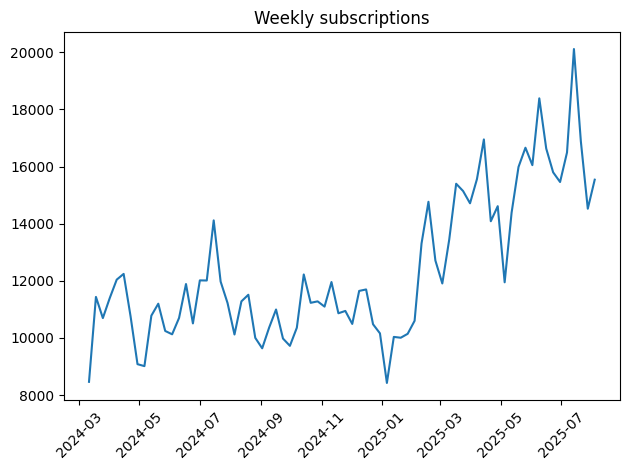

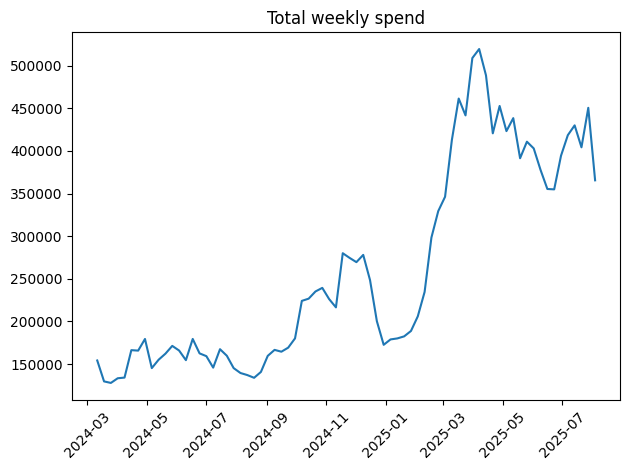

In [5]:
plt.figure()
plt.plot(df["date"], df["subscriptions"])
plt.title("Weekly subscriptions")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(df["date"], df["total_spend"])
plt.title("Total weekly spend")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [6]:
corr = df[["subscriptions"] + spend_cols].corr(numeric_only=True)["subscriptions"].sort_values(ascending=False)
print(corr)

subscriptions       1.000000
beehiiv_spend       0.849558
google_spend        0.716821
liveintent_spend    0.656964
moloco_spend        0.472630
meta_spend          0.191991
snapchat_spend      0.085298
tiktok_spend       -0.041041
amazon_spend       -0.087797
roku_spend               NaN
Name: subscriptions, dtype: float64


In [7]:
active = pd.DataFrame({
    "channel": channels,
    "active_weeks": [(df[f"{ch}_spend"] > 0).sum() for ch in channels],
    "pct_active":   [100 * (df[f"{ch}_spend"] > 0).mean() for ch in channels],
})
active = active.sort_values("pct_active")
active

,channel,active_weeks,pct_active
6,roku,0,0.000000
8,amazon,3,4.054054
0,meta,19,25.675676
7,beehiiv,25,33.783784
3,tiktok,39,52.702703
2,snapchat,74,100.000000
5,liveintent,74,100.000000
1,google,74,100.000000
4,moloco,74,100.000000


## Modeling

In [8]:
df_model = df.copy()

df_model['time'] = df_model['date']

# KPI + revenue per KPI (given: $100 revenue per subscription)
df_model["kpi"] = df_model["subscriptions"].astype(float)
df_model["revenue_per_kpi"] = 100.0

# Drop channels that I decided to remove (minimum-active theshold of 5 weeks)
DROP_CHANNELS = {"roku", "amazon"}

channels = sorted([c.replace("_spend","") for c in spend_cols if c.replace("_spend","") not in DROP_CHANNELS])

media_cols_raw  = [f"{ch}_impressions" for ch in channels]
spend_cols_keep = [f"{ch}_spend"       for ch in channels]

# Scale impressions to millions
for ch in channels:
    df_model[f"{ch}_impressions_m"] = df_model[f"{ch}_impressions"] / 1e6

media_cols = [f"{ch}_impressions_m" for ch in channels]

In [9]:
# Trend + seasonality controls
t = np.arange(len(df_model))
df_model["trend"] = (t - t.mean()) / t.std()

period = 52.0
df_model["sin_52_1"] = np.sin(2*np.pi*t/period)
df_model["cos_52_1"] = np.cos(2*np.pi*t/period)

control_cols = ["trend", "sin_52_1", "cos_52_1"]

In [10]:
builder = data_builder.DataFrameInputDataBuilder(
    kpi_type="non_revenue",
    default_kpi_column="kpi",
    default_revenue_per_kpi_column="revenue_per_kpi",
)

builder = (
    builder
      .with_kpi(df_model)
      .with_revenue_per_kpi(df_model)
      .with_controls(df_model, control_cols=control_cols)
      .with_media(
          df_model,
          media_cols=media_cols,
          media_spend_cols=spend_cols_keep,
          media_channels=channels,
      )
)

data = builder.build()

In [11]:
n_times = len(df_model)
holdout = np.zeros(n_times, dtype=bool)
holdout[-8:] = True

In [81]:
# ROI prior: median ~ 1.0, wide uncertainty
roi_mu = 0.0
roi_sigma = 1.0

prior = prior_distribution.PriorDistribution(
    roi_m=tfp.distributions.LogNormal(roi_mu, roi_sigma, name=constants.ROI_M)
)

model_spec = spec.ModelSpec(
    prior=prior,
    holdout_id=holdout,
    max_lag=8,
    enable_aks=True
)

mmm = model.Meridian(input_data=data, model_spec=model_spec)

mmm.sample_prior(1000)

mmm.sample_posterior(
    n_chains=4,
    n_adapt=1500,
    n_burnin=500,
    n_keep=2000,   # 4 * 2000 = 8000 draws
    seed=0
)

/usr/local/lib/python3.12/dist-packages/meridian/model/model.py:74: UserWarning: In a nationally aggregated model, the `media_effects_dist` will be reset to `normal`.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/meridian/model/prior_distribution.py:1265: UserWarning: Hierarchical distribution parameters must be deterministically zero for national models. tau_g_excl_baseline has been automatically set to Deterministic(0).
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/meridian/model/prior_distribution.py:1265: UserWarning: Hierarchical distribution parameters must be deterministically zero for national models. eta_m has been automatically set to Deterministic(0).
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/meridian/model/prior_distribution.py:1265: UserWarning: Hierarchical distribution parameters must be deterministically zero for national models. eta_rf has been automatically set to Deterministic(0).
  warnings.warn(
/usr/local/lib/python3.12/dist-pa

## Results

In [93]:
# Automated checks (convergence, baseline sanity, fit metrics, etc.)
reviewer.ModelReviewer(mmm).run()

/usr/local/lib/python3.12/dist-packages/meridian/analysis/analyzer.py:629: UserWarning: The `aggregate_geos` argument is ignored in the national model. It will be reset to `True`.
  warnings.warn(


Model Quality Checks
Overall Status: PASS
Summary: Passed with reviews: Review is needed.

Check Results:
----------------------------------------
Convergence Check:
  Status: PASS
  Recommendation: The model has likely converged, as all parameters have R-hat values < 1.2.
----------------------------------------
Baseline Check:
  Status: PASS
  Recommendation: The posterior probability that the baseline is negative is 0.00. We recommend visually inspecting the baseline time series in the Model Fit charts to confirm this.
----------------------------------------
BayesianPPP Check:
  Status: PASS
  Recommendation: The Bayesian posterior predictive p-value is 0.75. The observed total outcome is consistent with the model's posterior predictive distribution.
----------------------------------------
GoodnessOfFit Check:
  Status: REVIEW
  Recommendation: R-squared = 0.7349 (All), 0.9071 (Train), -3.9622 (Test); MAPE = 0.0628 (All), 0.0461 (Train), 0.2008 (Test); wMAPE = 0.0663 (All), 0.0453

In [94]:
# Fit plot (observed vs predicted)
visualizer.ModelFit(mmm, use_kpi=False).plot_model_fit()

/usr/local/lib/python3.12/dist-packages/meridian/analysis/analyzer.py:629: UserWarning: The `aggregate_geos` argument is ignored in the national model. It will be reset to `True`.
  warnings.warn(


alt.LayerChart(...)

In [95]:
# R-hat convergence view
visualizer.ModelDiagnostics(mmm).plot_rhat_boxplot()

alt.LayerChart(...)

## Iterate - Fix Issues

In [12]:
# Second seasonal harmonic due to small range of data
t = np.arange(len(df_model))
df_model["trend"] = (t - t.mean()) / t.std()

period = 52.0
df_model["sin_52_1"] = np.sin(2*np.pi*t/period)
df_model["cos_52_1"] = np.cos(2*np.pi*t/period)
df_model["sin_52_2"] = np.sin(4*np.pi*t/period)
df_model["cos_52_2"] = np.cos(4*np.pi*t/period)

control_cols = ["trend", "sin_52_1", "cos_52_1", "sin_52_2", "cos_52_2"]

In [13]:
H = 8
train_idx = np.arange(len(df_model) - H)
test_idx  = np.arange(len(df_model) - H, len(df_model))

media_cols = [f"{ch}_impressions_m" for ch in channels]
spend_cols_keep = [f"{ch}_spend" for ch in channels]

def compare_ranges(cols, name):
    train = df_model.loc[train_idx, cols]
    test  = df_model.loc[test_idx, cols]
    out_of_range = []
    for c in cols:
        if test[c].max() > train[c].max() * 1.05 or test[c].min() < train[c].min() * 0.95:
            out_of_range.append(c)
    print(f"{name}: out-of-range cols:", out_of_range)

compare_ranges(media_cols, "MEDIA")
compare_ranges(spend_cols_keep, "SPEND")

MEDIA: out-of-range cols: ['beehiiv_impressions_m', 'liveintent_impressions_m', 'meta_impressions_m']
SPEND: out-of-range cols: ['beehiiv_spend', 'liveintent_spend', 'meta_spend']


In [14]:
media_mat = df_model[[f"{ch}_impressions_m" for ch in channels]]
corr = media_mat.corr()
corr["liveintent_impressions_m"].sort_values(ascending=False)

,liveintent_impressions_m
liveintent_impressions_m,1.000000
beehiiv_impressions_m,0.700497
meta_impressions_m,0.602293
google_impressions_m,0.264783
snapchat_impressions_m,0.222100
moloco_impressions_m,0.049339
tiktok_impressions_m,-0.112239


In [15]:
# Merge media (in millions) and spend (in dollars)
df_model["newsletter_impressions_m"] = df_model["beehiiv_impressions_m"] + df_model["liveintent_impressions_m"]
df_model["newsletter_spend"] = df_model["beehiiv_spend"] + df_model["liveintent_spend"]

# Update channel lists: remove beehiiv/liveintent, add newsletter
channels_merged = [ch for ch in channels if ch not in ["beehiiv", "liveintent"]] + ["newsletter"]

media_cols_merged = [
    f"{ch}_impressions_m" for ch in channels_merged if ch != "newsletter"
] + ["newsletter_impressions_m"]

spend_cols_merged = [
    f"{ch}_spend" for ch in channels_merged if ch != "newsletter"
] + ["newsletter_spend"]

In [16]:
builder = data_builder.DataFrameInputDataBuilder(
    kpi_type="non_revenue",
    default_kpi_column="kpi",
    default_revenue_per_kpi_column="revenue_per_kpi",
)

builder = (
    builder
      .with_kpi(df_model)
      .with_revenue_per_kpi(df_model)
      .with_controls(df_model, control_cols=control_cols)
      .with_media(
          df_model,
          media_cols=media_cols_merged,
          media_spend_cols=spend_cols_merged,
          media_channels=channels_merged,
      )
)

data = builder.build()

In [21]:
# ROI prior: median ~ 1.0, wide uncertainty
roi_mu = 0.0
roi_sigma = 1.0

prior = prior_distribution.PriorDistribution(
    roi_m=tfp.distributions.LogNormal(roi_mu, roi_sigma, name=constants.ROI_M)
)

model_spec = spec.ModelSpec(
    prior=prior,
    holdout_id=holdout,
    max_lag=8,
    enable_aks=True
)

mmm = model.Meridian(input_data=data, model_spec=model_spec)

mmm.sample_prior(1000)

mmm.sample_posterior(
    n_chains=4,
    n_adapt=1500,
    n_burnin=500,
    n_keep=2000,   # 4 * 2000 = 8000 draws
    seed=0
)

/usr/local/lib/python3.12/dist-packages/meridian/model/model.py:74: UserWarning: In a nationally aggregated model, the `media_effects_dist` will be reset to `normal`.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/meridian/model/prior_distribution.py:1265: UserWarning: Hierarchical distribution parameters must be deterministically zero for national models. tau_g_excl_baseline has been automatically set to Deterministic(0).
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/meridian/model/prior_distribution.py:1265: UserWarning: Hierarchical distribution parameters must be deterministically zero for national models. eta_m has been automatically set to Deterministic(0).
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/meridian/model/prior_distribution.py:1265: UserWarning: Hierarchical distribution parameters must be deterministically zero for national models. eta_rf has been automatically set to Deterministic(0).
  warnings.warn(
/usr/local/lib/python3.12/dist-pa

In [18]:
# Automated checks (convergence, baseline sanity, fit metrics, etc.)
reviewer.ModelReviewer(mmm).run()

/usr/local/lib/python3.12/dist-packages/meridian/analysis/analyzer.py:629: UserWarning: The `aggregate_geos` argument is ignored in the national model. It will be reset to `True`.
  warnings.warn(


Model Quality Checks
Overall Status: PASS
Summary: Passed with reviews: Review is needed.

Check Results:
----------------------------------------
Convergence Check:
  Status: PASS
  Recommendation: The model has likely converged, as all parameters have R-hat values < 1.2.
----------------------------------------
Baseline Check:
  Status: PASS
  Recommendation: The posterior probability that the baseline is negative is 0.00. We recommend visually inspecting the baseline time series in the Model Fit charts to confirm this.
----------------------------------------
BayesianPPP Check:
  Status: PASS
  Recommendation: The Bayesian posterior predictive p-value is 0.99. The observed total outcome is consistent with the model's posterior predictive distribution.
----------------------------------------
GoodnessOfFit Check:
  Status: REVIEW
  Recommendation: R-squared = 0.8996 (All), 0.9202 (Train), -0.1766 (Test); MAPE = 0.0463 (All), 0.0432 (Train), 0.0721 (Test); wMAPE = 0.0474 (All), 0.0426

In [19]:
# Fit plot (observed vs predicted)
visualizer.ModelFit(mmm, use_kpi=False).plot_model_fit()

/usr/local/lib/python3.12/dist-packages/meridian/analysis/analyzer.py:629: UserWarning: The `aggregate_geos` argument is ignored in the national model. It will be reset to `True`.
  warnings.warn(


alt.LayerChart(...)

In [17]:
# ROI prior: median ~ 0.8 - slightly tighter sensitivity analysis
roi_mu = 0.0
roi_sigma = 0.8

prior = prior_distribution.PriorDistribution(
    roi_m=tfp.distributions.LogNormal(roi_mu, roi_sigma, name=constants.ROI_M)
)

model_spec = spec.ModelSpec(
    prior=prior,
    holdout_id=holdout,
    max_lag=8,
    enable_aks=True
)

mmm_2 = model.Meridian(input_data=data, model_spec=model_spec)

mmm_2.sample_prior(1000)

mmm_2.sample_posterior(
    n_chains=4,
    n_adapt=1500,
    n_burnin=500,
    n_keep=2000,   # 4 * 2000 = 8000 draws
    seed=0
)

/usr/local/lib/python3.12/dist-packages/meridian/model/model.py:74: UserWarning: In a nationally aggregated model, the `media_effects_dist` will be reset to `normal`.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/meridian/model/prior_distribution.py:1265: UserWarning: Hierarchical distribution parameters must be deterministically zero for national models. tau_g_excl_baseline has been automatically set to Deterministic(0).
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/meridian/model/prior_distribution.py:1265: UserWarning: Hierarchical distribution parameters must be deterministically zero for national models. eta_m has been automatically set to Deterministic(0).
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/meridian/model/prior_distribution.py:1265: UserWarning: Hierarchical distribution parameters must be deterministically zero for national models. eta_rf has been automatically set to Deterministic(0).
  warnings.warn(
/usr/local/lib/python3.12/dist-pa

In [18]:
# Automated checks (convergence, baseline sanity, fit metrics, etc.)
reviewer.ModelReviewer(mmm_2).run()

/usr/local/lib/python3.12/dist-packages/meridian/analysis/analyzer.py:629: UserWarning: The `aggregate_geos` argument is ignored in the national model. It will be reset to `True`.
  warnings.warn(


Model Quality Checks
Overall Status: PASS
Summary: Passed with reviews: Review is needed.

Check Results:
----------------------------------------
Convergence Check:
  Status: PASS
  Recommendation: The model has likely converged, as all parameters have R-hat values < 1.2.
----------------------------------------
Baseline Check:
  Status: PASS
  Recommendation: The posterior probability that the baseline is negative is 0.00. We recommend visually inspecting the baseline time series in the Model Fit charts to confirm this.
----------------------------------------
BayesianPPP Check:
  Status: PASS
  Recommendation: The Bayesian posterior predictive p-value is 0.97. The observed total outcome is consistent with the model's posterior predictive distribution.
----------------------------------------
GoodnessOfFit Check:
  Status: REVIEW
  Recommendation: R-squared = 0.8933 (All), 0.9190 (Train), -0.3094 (Test); MAPE = 0.0469 (All), 0.0434 (Train), 0.0758 (Test); wMAPE = 0.0482 (All), 0.0427

In [19]:
# Fit plot (observed vs predicted)
visualizer.ModelFit(mmm_2, use_kpi=False).plot_model_fit()

/usr/local/lib/python3.12/dist-packages/meridian/analysis/analyzer.py:629: UserWarning: The `aggregate_geos` argument is ignored in the national model. It will be reset to `True`.
  warnings.warn(


alt.LayerChart(...)

## Final Results

In [20]:
media_summary = visualizer.MediaSummary(mmm, use_kpi=False)  # use revenue via revenue_per_kpi=100

summary_tbl = media_summary.summary_table(include_prior=False, include_posterior=True)
summary_tbl

/usr/local/lib/python3.12/dist-packages/meridian/analysis/visualizer.py:1624: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  .aggregate(lambda g: f'{g[0]} ({g[1]}, {g[2]})')


,channel,distribution,impressions,% impressions,spend,% spend,cpm,incremental outcome,% contribution,roi,effectiveness,mroi,cpik
0,google,posterior,460,47%,"$10,298,544",54%,"$22,381,010","$7,213,184 ($1,338,402, $18,703,056)","7.9% (1.5%, 20.4%)","0.7 (0.1, 1.8)","15,675.82 (2,908.64, 40,645.87)","0.3 (0.0, 0.7)","$186 ($55, $769)"
1,meta,posterior,193,20%,"$840,158",4%,"$4,361,794","$1,700,618 ($194,497, $5,345,034)","1.9% (0.2%, 5.8%)","2.0 (0.2, 6.4)","8,828.99 (1,009.76, 27,749.46)","1.2 (0.1, 3.9)","$76 ($16, $432)"
2,moloco,posterior,38,4%,"$842,235",4%,"$22,407,604","$1,788,092 ($190,735, $5,447,500)","2.0% (0.2%, 5.9%)","2.1 (0.2, 6.5)","47,572.17 (5,074.50, 144,930.44)","0.8 (0.1, 2.5)","$73 ($15, $442)"
3,snapchat,posterior,200,20%,"$4,342,437",23%,"$21,668,050","$4,448,082 ($711,807, $12,506,747)","4.9% (0.8%, 13.7%)","1.0 (0.2, 2.9)","22,195.25 (3,551.80, 62,406.62)","0.5 (0.1, 1.4)","$137 ($35, $610)"
4,tiktok,posterior,80,8%,"$1,752,685",9%,"$21,920,842","$1,741,754 ($277,840, $4,793,768)","1.9% (0.3%, 5.2%)","1.0 (0.2, 2.7)","21,784.13 (3,474.94, 59,955.69)","0.5 (0.1, 1.5)","$137 ($37, $631)"
5,newsletter,posterior,12,1%,"$1,126,160",6%,"$92,001,064","$1,729,627 ($210,747, $5,370,200)","1.9% (0.2%, 5.9%)","1.5 (0.2, 4.8)","141,300.80 (17,216.84, 438,715.94)","0.6 (0.1, 2.0)","$101 ($21, $534)"
6,All Channels,posterior,983,100%,"$19,202,218",100%,"$19,535,208","$18,621,382 ($8,624,272, $33,412,890)","20.3% (9.4%, 36.5%)","1.0 (0.4, 1.7)","nan (nan, nan)","nan (nan, nan)","$112 ($57, $223)"


In [21]:
media_summary.plot_contribution_waterfall_chart()

alt.LayerChart(...)

In [22]:
media_summary.plot_spend_vs_contribution()

alt.FacetChart(...)

In [23]:
contrib_df = media_summary.contribution_metrics(aggregate_times=True)
contrib_df

,channel,incremental_outcome,pct_of_contribution
0,baseline,7.293906e+07,0.796622
1,google,7.213184e+06,0.078781
4,snapchat,4.448082e+06,0.048581
3,moloco,1.788092e+06,0.019529
5,tiktok,1.741754e+06,0.019023
6,newsletter,1.729627e+06,0.018891
2,meta,1.700618e+06,0.018574


In [24]:
media_summary.plot_roi_bar_chart()
media_summary.plot_roi_vs_mroi(equal_axes=True)         # efficiency vs saturation
media_summary.plot_roi_vs_effectiveness(disable_size=False)

alt.Chart(...)

In [26]:
media_effects = visualizer.MediaEffects(mmm, use_kpi=False)

media_effects.plot_response_curves(plot_separately=True)

alt.FacetChart(...)

In [27]:
media_effects.plot_adstock_decay()

alt.FacetChart(...)

In [31]:
budget_optimizer = optimizer.BudgetOptimizer(mmm)
build_ch = mmm.input_data.get_paid_channels_argument_builder()

# Use last 8 weeks spend shares as baseline allocation
H = 8
spend_last = df_model.iloc[-H:][spend_cols_merged].sum()
pct = (spend_last / spend_last.sum()).to_dict()

pct_of_spend = {k.replace("_spend",""): float(v) for k, v in pct.items()}

opt = budget_optimizer.optimize(
    pct_of_spend=build_ch(**pct_of_spend),
    spend_constraint_lower=0.3,
    spend_constraint_upper=0.3,
    use_kpi=False,
)

opt.optimized_data

<xarray.Dataset> Size: 1kB
Dimensions:              (channel: 6, metric: 4)
Coordinates:
  * channel              (channel) object 48B 'google' 'meta' ... 'newsletter'
  * metric               (metric) <U6 96B 'mean' 'median' 'ci_lo' 'ci_hi'
Data variables:
    spend                (channel) float64 48B 7.69e+06 2.99e+06 ... 1.86e+06
    pct_of_spend         (channel) float64 48B 0.4003 0.1556 ... 0.0 0.09682
    incremental_outcome  (channel, metric) float64 192B 6.428e+06 ... 6.567e+06
    effectiveness        (channel, metric) float64 192B 1.871e+04 ... 3.248e+05
    roi                  (channel, metric) float64 192B 0.8359 0.6389 ... 3.531
    mroi                 (channel, metric) float64 192B 0.3624 0.2704 ... 1.196
    cpik                 (channel, metric) float64 192B 2.306 1.565 ... 7.21
Attributes:
    start_date:                 2024-03-11
    end_date:                   2025-08-04
    budget:                     19210000.0
    profit:                     -660766.0
    total_incremental_outcome:  18549234.0
    total_roi:                  0.965603
    total_cpik:                 tf.Tensor(1.2533921, shape=(), dtype=float32)
    is_revenue_kpi:             True
    confidence_level:           0.9
    use_historical_budget:      True
    fixed_budget:               True

In [32]:
def as_df(xr_ds, label):
    df = xr_ds.to_dataframe().reset_index()
    df["scenario"] = label
    return df

nonopt_df = as_df(opt.nonoptimized_data, "current")
opt_df    = as_df(opt.optimized_data, "optimized")

comp = pd.concat([nonopt_df, opt_df], ignore_index=True)

comp

,channel,metric,spend,pct_of_spend,incremental_outcome,effectiveness,roi,mroi,cpik,scenario
0,google,mean,9160000.0,0.476835,6.919022e+06,16905.550781,0.755352,0.305368,2.538890,current
1,google,median,9160000.0,0.476835,5.289100e+06,12923.079102,0.577413,0.227126,1.731863,current
2,google,ci_lo,9160000.0,0.476835,1.283544e+06,3136.136963,0.140125,0.050132,0.512482,current
3,google,ci_hi,9160000.0,0.476835,1.787379e+07,43671.781250,1.951287,0.837878,7.136488,current
4,meta,mean,2300000.0,0.119729,2.827555e+06,5362.271973,1.229372,0.524456,2.266335,current
5,meta,median,2300000.0,0.119729,1.790650e+06,3395.846680,0.778544,0.296927,1.284450,current
6,meta,ci_lo,2300000.0,0.119729,3.043612e+05,577.200317,0.132331,0.039797,0.259775,current
7,meta,ci_hi,2300000.0,0.119729,8.853803e+06,16790.638672,3.849480,1.774615,7.556811,current
8,moloco,mean,880000.0,0.045809,1.821289e+06,46375.714844,2.069641,0.751296,1.339636,current
9,moloco,median,880000.0,0.045809,1.188866e+06,30272.316406,1.350984,0.472180,0.740201,current


In [36]:
pivot = comp.pivot_table(index="channel", columns="scenario", values="pct_of_spend")
pivot["delta"] = pivot["optimized"] - pivot["current"]
pivot.sort_values("delta", ascending=False)

scenario,current,optimized,delta
channel,,,
snapchat,0.222801,0.287871,0.065070
meta,0.119729,0.155648,0.035919
moloco,0.045809,0.059344,0.013535
tiktok,0.000000,0.000000,0.000000
newsletter,0.134826,0.096825,-0.038001
google,0.476835,0.400312,-0.076523
